# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use the first clustering approach (the basic version) (random exploration)

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [3]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [4]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [5]:
#############################
### Essentials functions ###
#############################
import clustering as cl
import sys
sys.path.append("..")
import FunctionMain as fm

In [6]:
# ----------------- Parameters

# The file to consider
file = '../file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20



# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [7]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
# list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n,optimalval, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...


Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 4319
Le max de list_obj est 5369
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000001B7B0B96AC0>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7A8B1CD40>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7B11B8240>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7A93264C0>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7A8AA6EC0>], [<docplex.cp.solution.CpoSolveResult object at 0x000001B7AFF4C5C0>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7AD50A8C0>, <docplex.cp.solution.CpoSolveResult object at 0x000001B7B2D5A3C0>], [<docplex.cp.solution.CpoSolveResult obj

In [8]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################


###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    if it > 1:
        model, variables = solver.create_constraints(model, n, m, list_min_obj_global[it-1], T_machine)
    else :
        model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    
    #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)

    it += 1


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 5
-------------- Layer 1 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 2 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 3 -----------------
Number of clusters : 0
Number of solutions : 0
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...
The number of solutions generated is : 5697
Objective function : [4319, 4194]
Model solved !

Classing solutions...
Le min de list_obj est 4194
Le max de list_obj est 5369
Solutions classed !

Creating preferences...
Preferences created !
Il y a 

In [9]:
# ####################################################################
# #### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
# ####################################################################

# import decision_tree as dt

# ###  -------------- Iteration of the solver with the preferences
# it = 1
# tps = runtime
# list_min_obj = [min(list_obj)]
# list_min_obj_global = [min(list_obj)]

# criterion = (tps < tps_max) and (it < it_max) 

# # ----------------- Add the preferences to the model
# while criterion :
#     print("\n--------Iteration {}---------".format(it))
#     clf, feuilles_conditions = dt.my_decision_tree(n, m, list_layers)

#     # --------- Call Solver constructor in Solver.py and create the variables of the model
#     model, solver, tasks = fm.initialize_solver(data, n, m, duration)

#     # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
#     variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    
#     order = model.binary_var(name="order")
#     solver.add_variable(order)
#     # --------- Add the new constraints to the model (concerning the order)
#     list_variables = [model.start_of(variables[i//m][i%m]) for i in range(n*m)]
#     constraint_list_of_tree = dt.constraint_tree(order,list_variables, feuilles_conditions)

#     for constraint in constraint_list_of_tree:
#         solver.add_constraint(model, constraint)
#     solver.add_constraint(model, equal(order, 1))

    
    

#     # ------------ Solve the model
#     print("\nSolving the model...")
#     # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
#     model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
#     msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
#     print("The number of solutions generated is :",nb_solution)
#     list = []
#     for sol in msol:
#         list.append(user.objectiveFunction(sol))

#     list_min_obj.append(min(list))
#     print("Objective function :", list_min_obj)

#     # ------------ Display the result
#     fm.display_solution(msol, display_sol)
#     print("Model solved !")

#     # ---------------- Interaction with the user
#     # list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
#     list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, optimalval, m)
#     print("Il y a {} solution(s)".format(len(pref)))

#     list_min_obj_global.append(min(list_obj))
#     print("Objective function global :", list_min_obj_global)

#     # Vector of the start time of each task of each preference
#     starts = user.start_pref(n, m, display_start)

#     # Matrix of the start time of each task of each preference
#     matrix = user.matrix_pref(n, m, display_matrix)

#     # Testing the order of preferences and the differences between solutions
#     fm.test(n, m, user)


# #------------------ Condition d'arrêt ------------------
#     tps += runtime
#     criterion = (tps < tps_max) and (it < it_max)
#     fm.stopCondition(it, it_max, tps, tps_max)

#     it += 1

[4319, 4194, 4189, 6681, 8585, 4142, 3957, 3977, 4009, 4012, 3932, 4113, 3983, 4087, 3950]


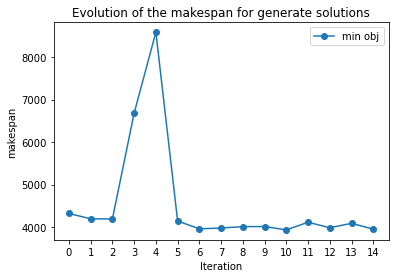

In [10]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[4319, 4194, 4189, 4189, 4189, 4142, 3957, 3957, 3957, 3957, 3932, 3932, 3932, 3932, 3932]


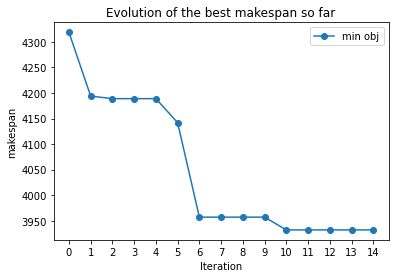

In [11]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

150


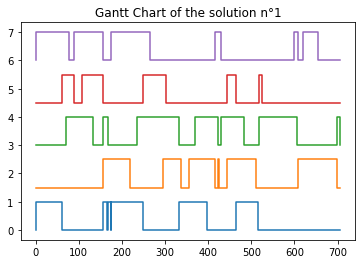

Makespan of the solution n°1 : 706
Regularity of the solution n°1 : 3226
Objective function of the solution n°1 : 2277556


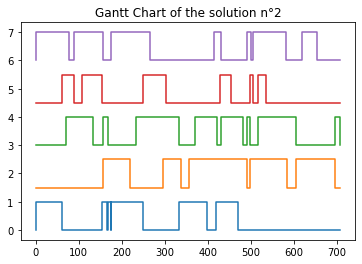

Makespan of the solution n°2 : 708
Regularity of the solution n°2 : 3242
Objective function of the solution n°2 : 2295336


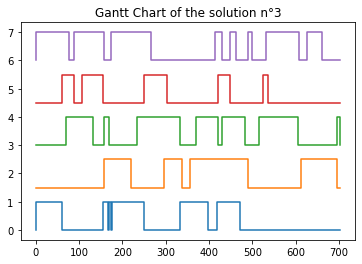

Makespan of the solution n°3 : 703
Regularity of the solution n°3 : 3254
Objective function of the solution n°3 : 2287562


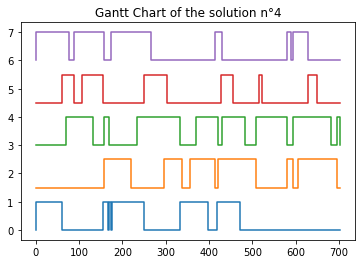

Makespan of the solution n°4 : 703
Regularity of the solution n°4 : 3274
Objective function of the solution n°4 : 2301622


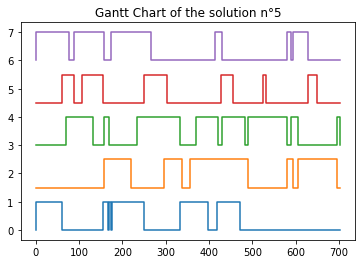

Makespan of the solution n°5 : 703
Regularity of the solution n°5 : 3280
Objective function of the solution n°5 : 2305840


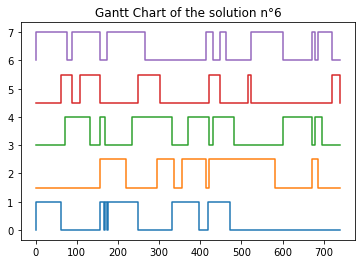

Makespan of the solution n°6 : 740
Regularity of the solution n°6 : 3252
Objective function of the solution n°6 : 2406480


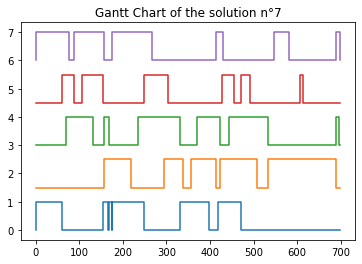

Makespan of the solution n°7 : 699
Regularity of the solution n°7 : 3310
Objective function of the solution n°7 : 2313690


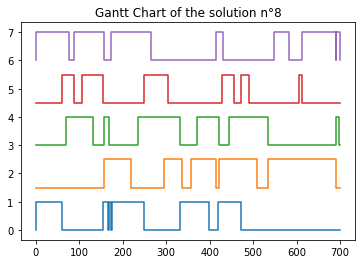

Makespan of the solution n°8 : 700
Regularity of the solution n°8 : 3312
Objective function of the solution n°8 : 2318400


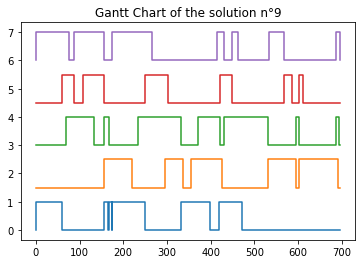

Makespan of the solution n°9 : 696
Regularity of the solution n°9 : 3320
Objective function of the solution n°9 : 2310720


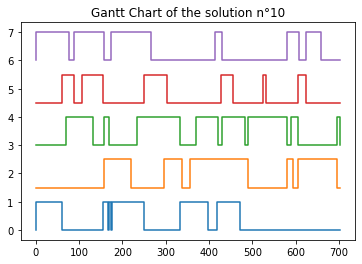

Makespan of the solution n°10 : 703
Regularity of the solution n°10 : 3320
Objective function of the solution n°10 : 2333960


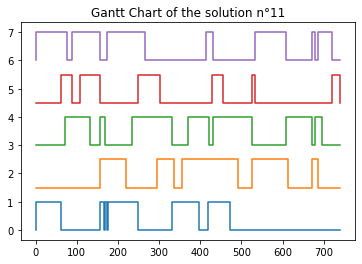

Makespan of the solution n°11 : 740
Regularity of the solution n°11 : 3306
Objective function of the solution n°11 : 2446440


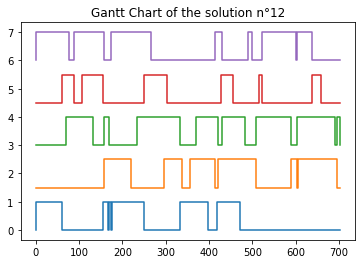

Makespan of the solution n°12 : 703
Regularity of the solution n°12 : 3346
Objective function of the solution n°12 : 2352238


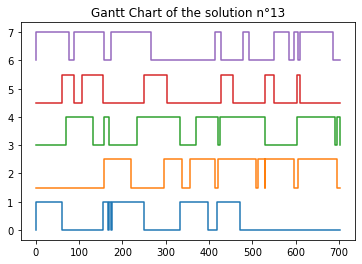

Makespan of the solution n°13 : 703
Regularity of the solution n°13 : 3374
Objective function of the solution n°13 : 2371922


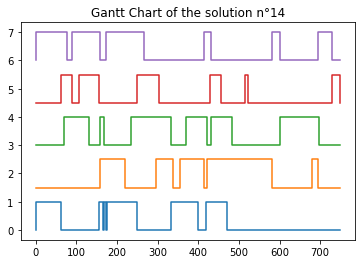

Makespan of the solution n°14 : 749
Regularity of the solution n°14 : 3338
Objective function of the solution n°14 : 2500162


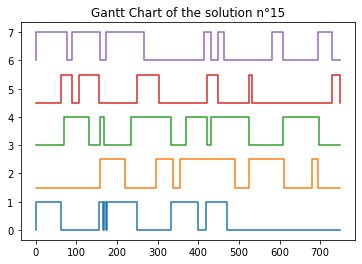

Makespan of the solution n°15 : 749
Regularity of the solution n°15 : 3364
Objective function of the solution n°15 : 2519636


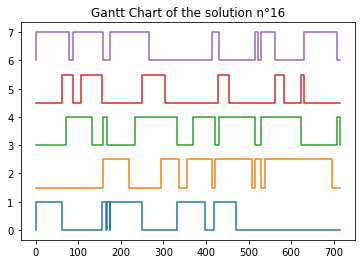

Makespan of the solution n°16 : 715
Regularity of the solution n°16 : 3400
Objective function of the solution n°16 : 2431000


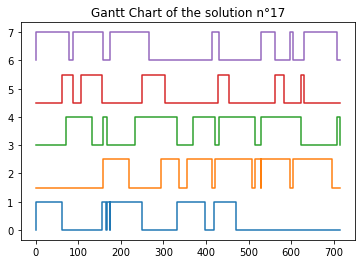

Makespan of the solution n°17 : 715
Regularity of the solution n°17 : 3400
Objective function of the solution n°17 : 2431000


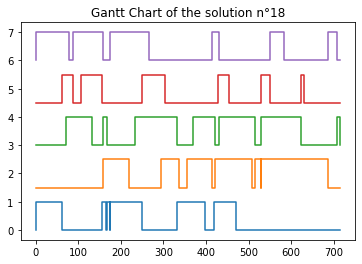

Makespan of the solution n°18 : 715
Regularity of the solution n°18 : 3404
Objective function of the solution n°18 : 2433860


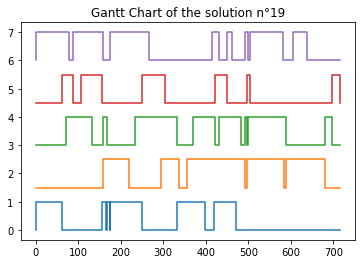

Makespan of the solution n°19 : 716
Regularity of the solution n°19 : 3412
Objective function of the solution n°19 : 2442992


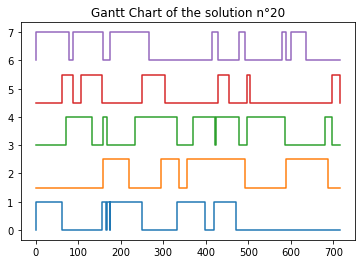

Makespan of the solution n°20 : 716
Regularity of the solution n°20 : 3426
Objective function of the solution n°20 : 2453016


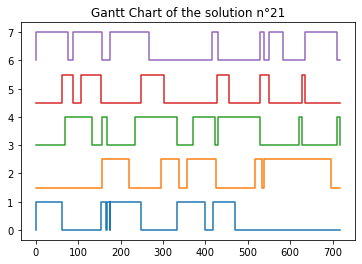

Makespan of the solution n°21 : 718
Regularity of the solution n°21 : 3428
Objective function of the solution n°21 : 2461304


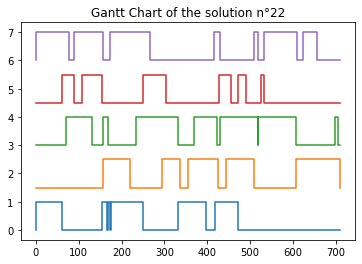

Makespan of the solution n°22 : 710
Regularity of the solution n°22 : 3436
Objective function of the solution n°22 : 2439560


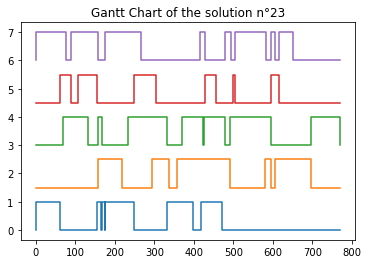

Makespan of the solution n°23 : 770
Regularity of the solution n°23 : 3388
Objective function of the solution n°23 : 2608760


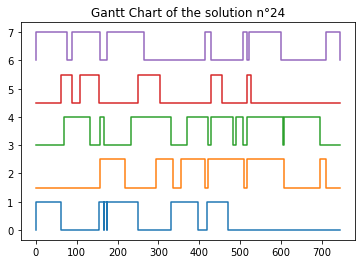

Makespan of the solution n°24 : 745
Regularity of the solution n°24 : 3414
Objective function of the solution n°24 : 2543430


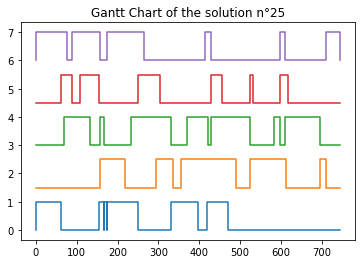

Makespan of the solution n°25 : 745
Regularity of the solution n°25 : 3426
Objective function of the solution n°25 : 2552370


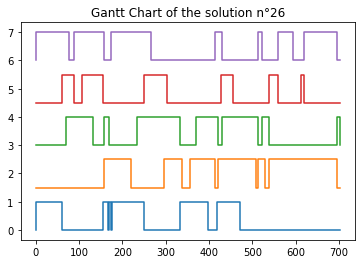

Makespan of the solution n°26 : 703
Regularity of the solution n°26 : 3482
Objective function of the solution n°26 : 2447846


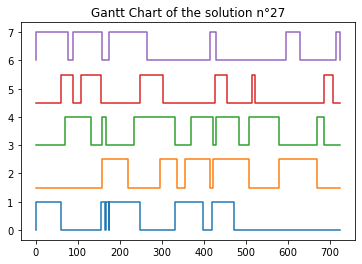

Makespan of the solution n°27 : 725
Regularity of the solution n°27 : 3464
Objective function of the solution n°27 : 2511400


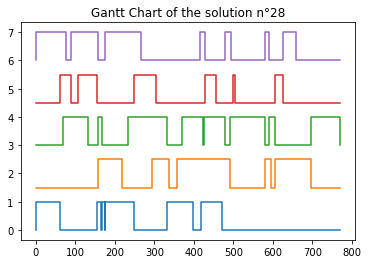

Makespan of the solution n°28 : 770
Regularity of the solution n°28 : 3424
Objective function of the solution n°28 : 2636480


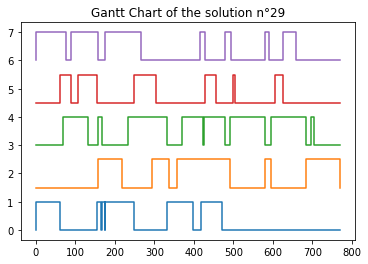

Makespan of the solution n°29 : 770
Regularity of the solution n°29 : 3424
Objective function of the solution n°29 : 2636480


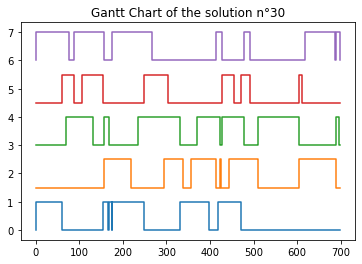

Makespan of the solution n°30 : 699
Regularity of the solution n°30 : 3534
Objective function of the solution n°30 : 2470266


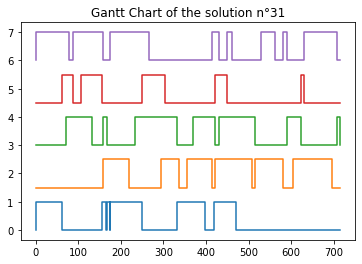

Makespan of the solution n°31 : 715
Regularity of the solution n°31 : 3554
Objective function of the solution n°31 : 2541110


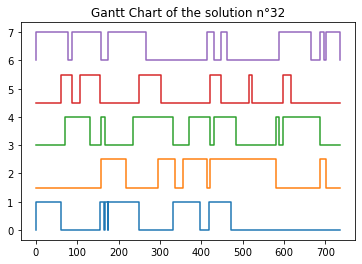

Makespan of the solution n°32 : 736
Regularity of the solution n°32 : 3536
Objective function of the solution n°32 : 2602496


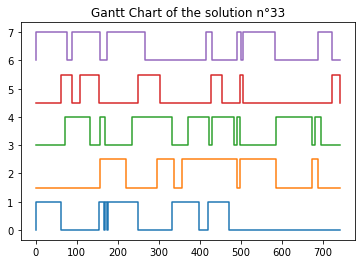

Makespan of the solution n°33 : 742
Regularity of the solution n°33 : 3530
Objective function of the solution n°33 : 2619260


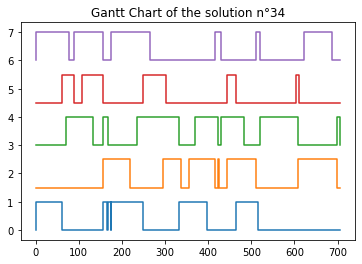

Makespan of the solution n°34 : 706
Regularity of the solution n°34 : 3586
Objective function of the solution n°34 : 2531716


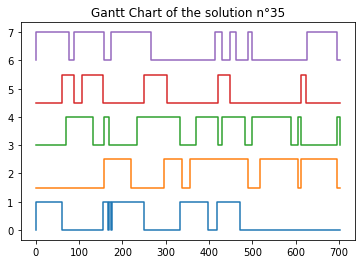

Makespan of the solution n°35 : 703
Regularity of the solution n°35 : 3602
Objective function of the solution n°35 : 2532206


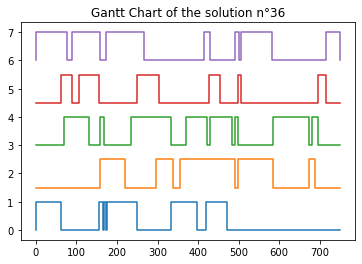

Makespan of the solution n°36 : 750
Regularity of the solution n°36 : 3562
Objective function of the solution n°36 : 2671500


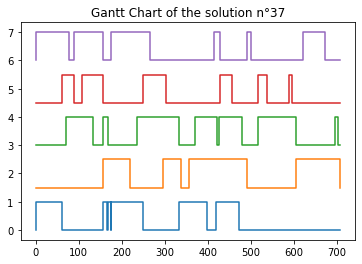

Makespan of the solution n°37 : 707
Regularity of the solution n°37 : 3610
Objective function of the solution n°37 : 2552270


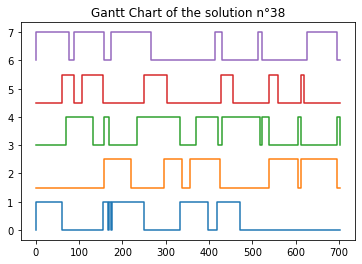

Makespan of the solution n°38 : 703
Regularity of the solution n°38 : 3616
Objective function of the solution n°38 : 2542048


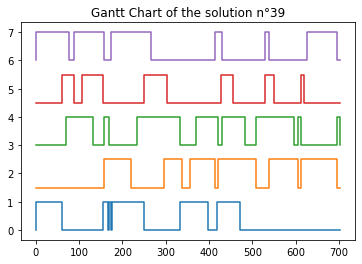

Makespan of the solution n°39 : 703
Regularity of the solution n°39 : 3616
Objective function of the solution n°39 : 2542048


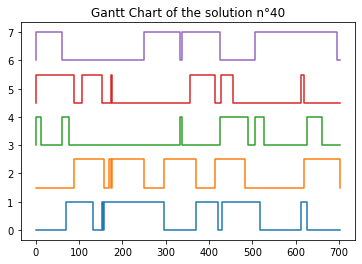

Makespan of the solution n°40 : 703
Regularity of the solution n°40 : 3616
Objective function of the solution n°40 : 2542048


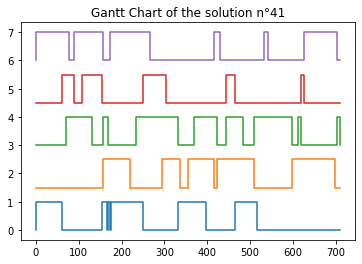

Makespan of the solution n°41 : 710
Regularity of the solution n°41 : 3618
Objective function of the solution n°41 : 2568780


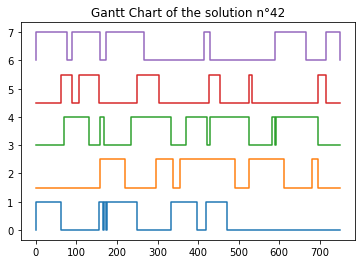

Makespan of the solution n°42 : 750
Regularity of the solution n°42 : 3582
Objective function of the solution n°42 : 2686500


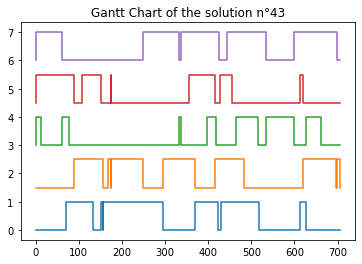

Makespan of the solution n°43 : 706
Regularity of the solution n°43 : 3634
Objective function of the solution n°43 : 2565604


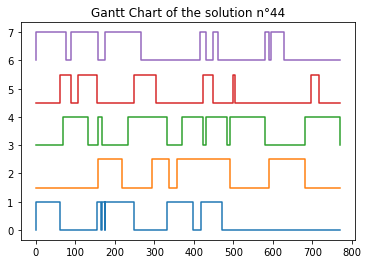

Makespan of the solution n°44 : 770
Regularity of the solution n°44 : 3574
Objective function of the solution n°44 : 2751980


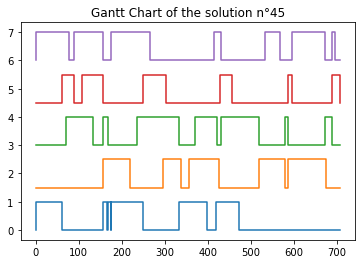

Makespan of the solution n°45 : 707
Regularity of the solution n°45 : 3644
Objective function of the solution n°45 : 2576308


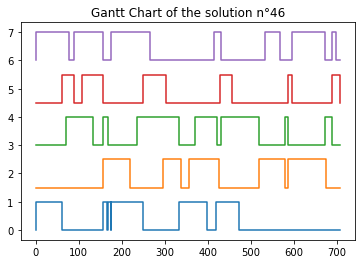

Makespan of the solution n°46 : 707
Regularity of the solution n°46 : 3646
Objective function of the solution n°46 : 2577722


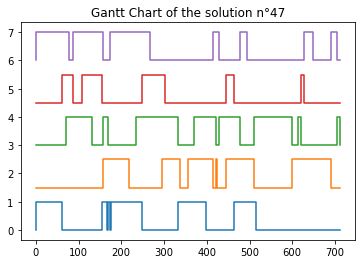

Makespan of the solution n°47 : 712
Regularity of the solution n°47 : 3642
Objective function of the solution n°47 : 2593104


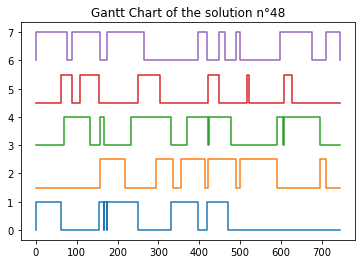

Makespan of the solution n°48 : 745
Regularity of the solution n°48 : 3644
Objective function of the solution n°48 : 2714780


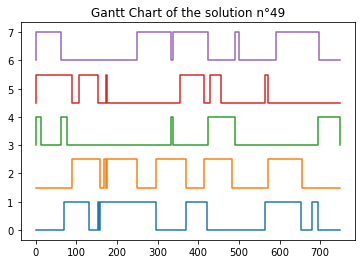

Makespan of the solution n°49 : 749
Regularity of the solution n°49 : 3644
Objective function of the solution n°49 : 2729356


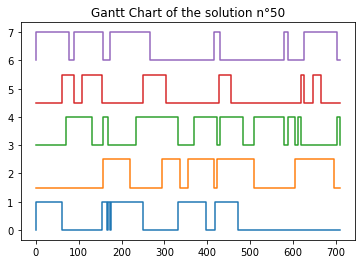

Makespan of the solution n°50 : 710
Regularity of the solution n°50 : 3692
Objective function of the solution n°50 : 2621320


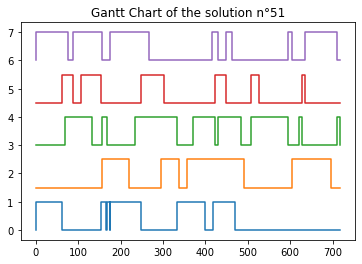

Makespan of the solution n°51 : 718
Regularity of the solution n°51 : 3694
Objective function of the solution n°51 : 2652292


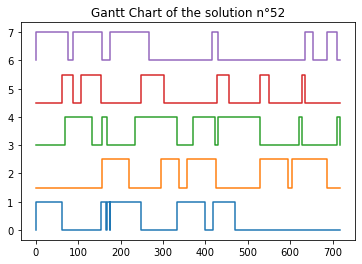

Makespan of the solution n°52 : 718
Regularity of the solution n°52 : 3708
Objective function of the solution n°52 : 2662344


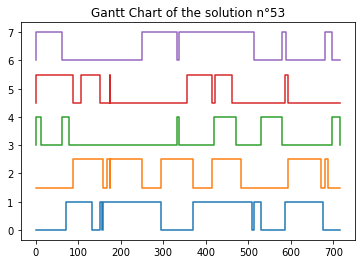

Makespan of the solution n°53 : 716
Regularity of the solution n°53 : 3710
Objective function of the solution n°53 : 2656360


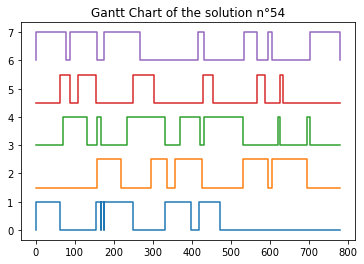

Makespan of the solution n°54 : 780
Regularity of the solution n°54 : 3688
Objective function of the solution n°54 : 2876640


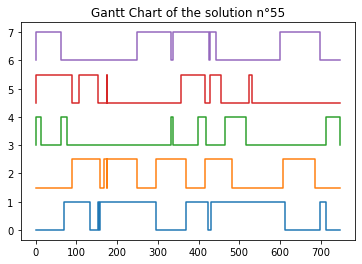

Makespan of the solution n°55 : 748
Regularity of the solution n°55 : 3732
Objective function of the solution n°55 : 2791536


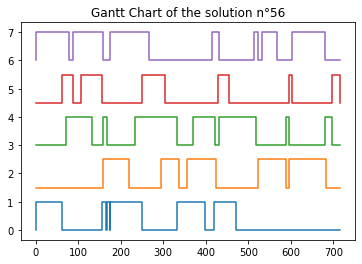

Makespan of the solution n°56 : 716
Regularity of the solution n°56 : 3770
Objective function of the solution n°56 : 2699320


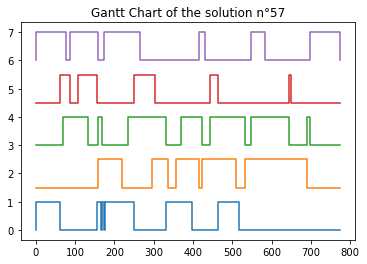

Makespan of the solution n°57 : 774
Regularity of the solution n°57 : 3714
Objective function of the solution n°57 : 2874636


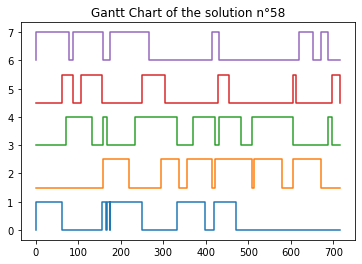

Makespan of the solution n°58 : 716
Regularity of the solution n°58 : 3772
Objective function of the solution n°58 : 2700752


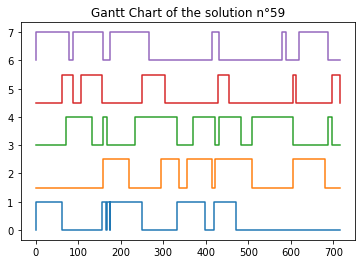

Makespan of the solution n°59 : 716
Regularity of the solution n°59 : 3772
Objective function of the solution n°59 : 2700752


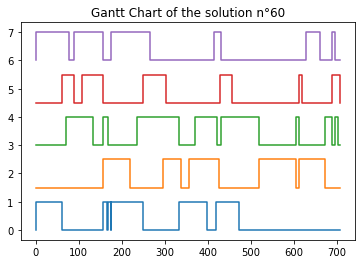

Makespan of the solution n°60 : 707
Regularity of the solution n°60 : 3800
Objective function of the solution n°60 : 2686600


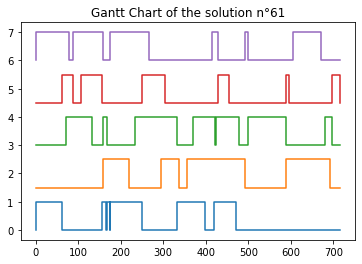

Makespan of the solution n°61 : 716
Regularity of the solution n°61 : 3794
Objective function of the solution n°61 : 2716504


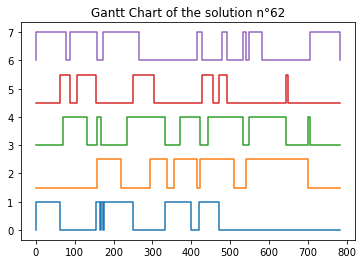

Makespan of the solution n°62 : 783
Regularity of the solution n°62 : 3750
Objective function of the solution n°62 : 2936250


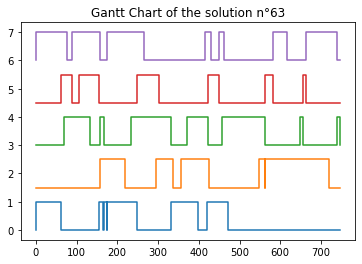

Makespan of the solution n°63 : 747
Regularity of the solution n°63 : 3834
Objective function of the solution n°63 : 2863998


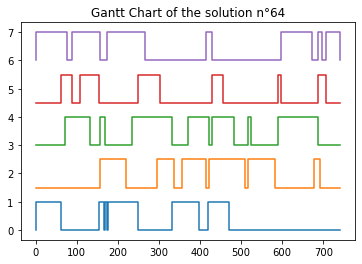

Makespan of the solution n°64 : 741
Regularity of the solution n°64 : 3850
Objective function of the solution n°64 : 2852850


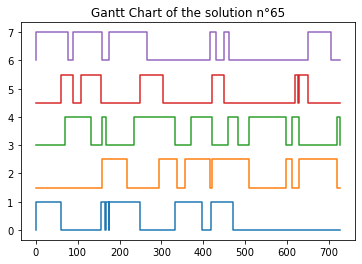

Makespan of the solution n°65 : 727
Regularity of the solution n°65 : 3866
Objective function of the solution n°65 : 2810582


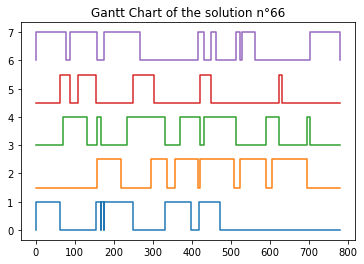

Makespan of the solution n°66 : 780
Regularity of the solution n°66 : 3814
Objective function of the solution n°66 : 2974920


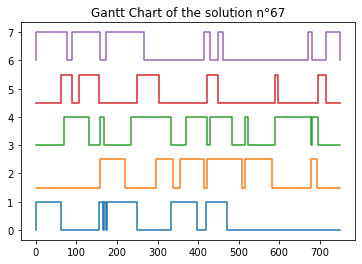

Makespan of the solution n°67 : 750
Regularity of the solution n°67 : 3872
Objective function of the solution n°67 : 2904000


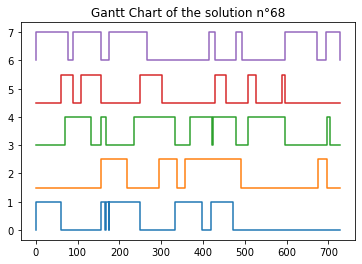

Makespan of the solution n°68 : 728
Regularity of the solution n°68 : 3906
Objective function of the solution n°68 : 2843568


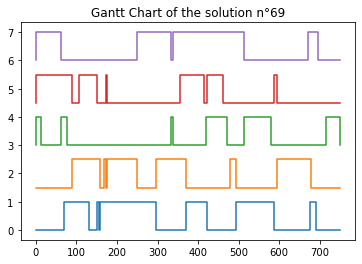

Makespan of the solution n°69 : 750
Regularity of the solution n°69 : 3884
Objective function of the solution n°69 : 2913000


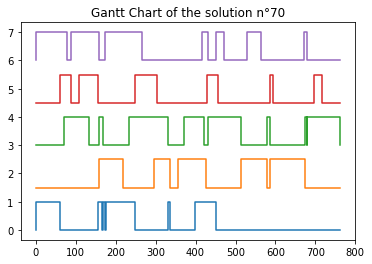

Makespan of the solution n°70 : 762
Regularity of the solution n°70 : 3890
Objective function of the solution n°70 : 2964180


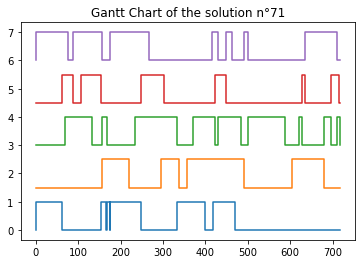

Makespan of the solution n°71 : 718
Regularity of the solution n°71 : 3942
Objective function of the solution n°71 : 2830356


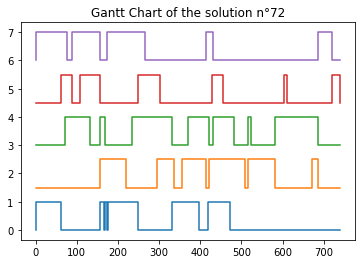

Makespan of the solution n°72 : 740
Regularity of the solution n°72 : 3942
Objective function of the solution n°72 : 2917080


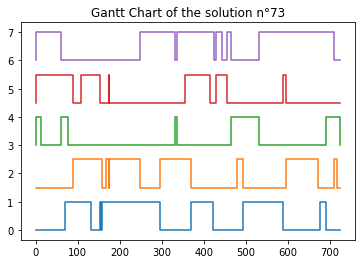

Makespan of the solution n°73 : 724
Regularity of the solution n°73 : 3974
Objective function of the solution n°73 : 2877176


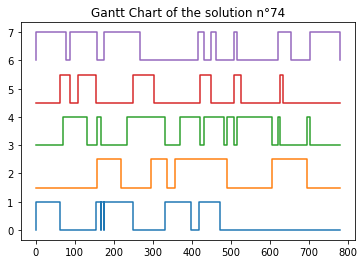

Makespan of the solution n°74 : 780
Regularity of the solution n°74 : 3942
Objective function of the solution n°74 : 3074760


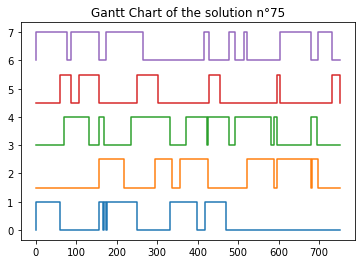

Makespan of the solution n°75 : 752
Regularity of the solution n°75 : 3970
Objective function of the solution n°75 : 2985440


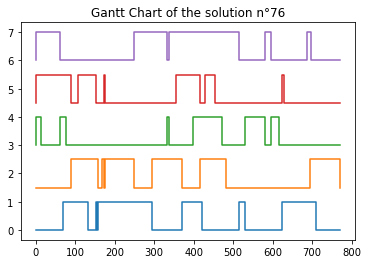

Makespan of the solution n°76 : 771
Regularity of the solution n°76 : 3954
Objective function of the solution n°76 : 3048534


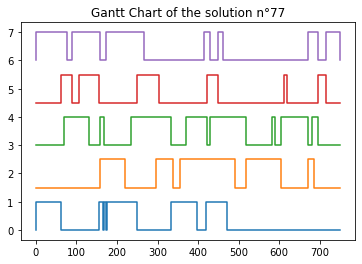

Makespan of the solution n°77 : 750
Regularity of the solution n°77 : 4000
Objective function of the solution n°77 : 3000000


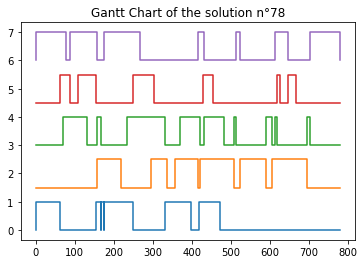

Makespan of the solution n°78 : 780
Regularity of the solution n°78 : 3972
Objective function of the solution n°78 : 3098160


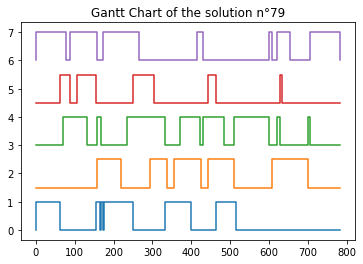

Makespan of the solution n°79 : 783
Regularity of the solution n°79 : 3974
Objective function of the solution n°79 : 3111642


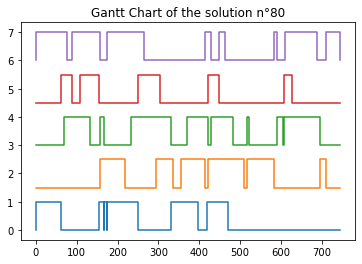

Makespan of the solution n°80 : 745
Regularity of the solution n°80 : 4048
Objective function of the solution n°80 : 3015760


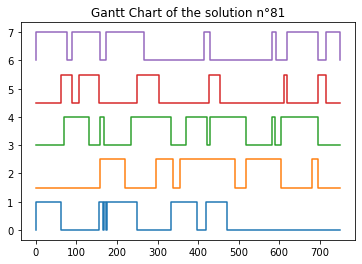

Makespan of the solution n°81 : 750
Regularity of the solution n°81 : 4050
Objective function of the solution n°81 : 3037500


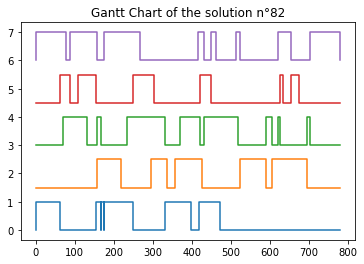

Makespan of the solution n°82 : 780
Regularity of the solution n°82 : 4022
Objective function of the solution n°82 : 3137160


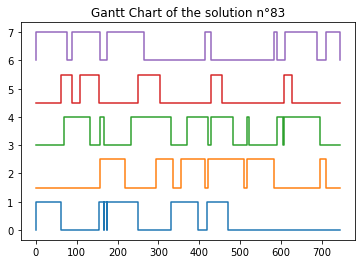

Makespan of the solution n°83 : 745
Regularity of the solution n°83 : 4062
Objective function of the solution n°83 : 3026190


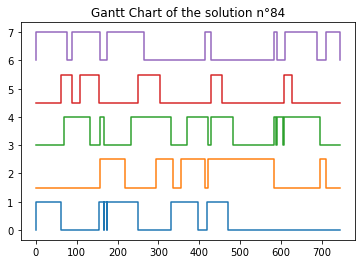

Makespan of the solution n°84 : 745
Regularity of the solution n°84 : 4062
Objective function of the solution n°84 : 3026190


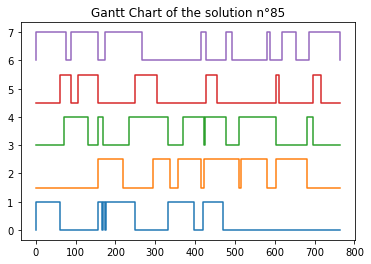

Makespan of the solution n°85 : 764
Regularity of the solution n°85 : 4048
Objective function of the solution n°85 : 3092672


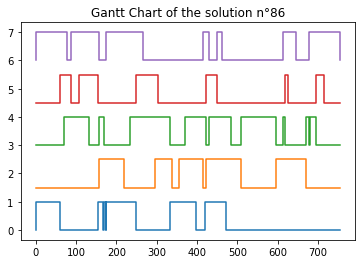

Makespan of the solution n°86 : 755
Regularity of the solution n°86 : 4058
Objective function of the solution n°86 : 3063790


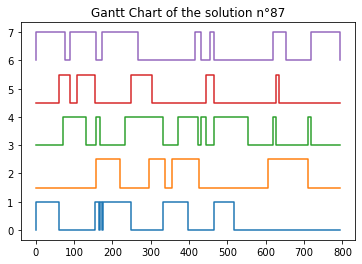

Makespan of the solution n°87 : 794
Regularity of the solution n°87 : 4040
Objective function of the solution n°87 : 3207760


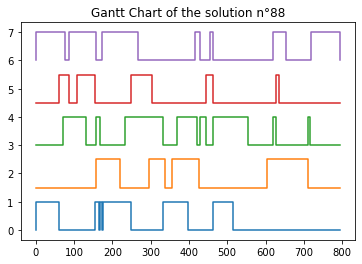

Makespan of the solution n°88 : 795
Regularity of the solution n°88 : 4044
Objective function of the solution n°88 : 3214980


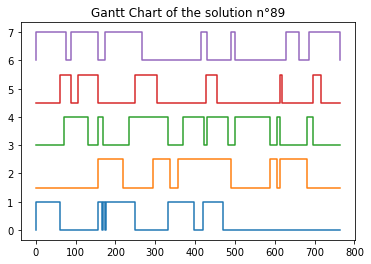

Makespan of the solution n°89 : 764
Regularity of the solution n°89 : 4080
Objective function of the solution n°89 : 3117120


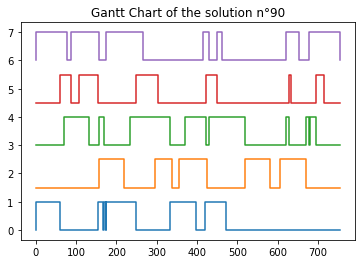

Makespan of the solution n°90 : 755
Regularity of the solution n°90 : 4090
Objective function of the solution n°90 : 3087950


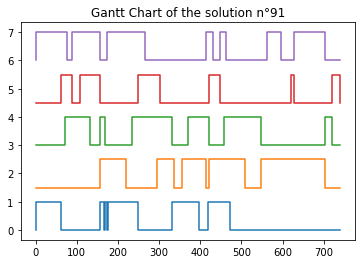

Makespan of the solution n°91 : 740
Regularity of the solution n°91 : 4108
Objective function of the solution n°91 : 3039920


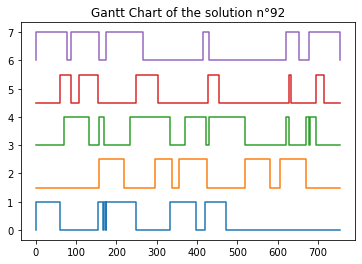

Makespan of the solution n°92 : 755
Regularity of the solution n°92 : 4104
Objective function of the solution n°92 : 3098520


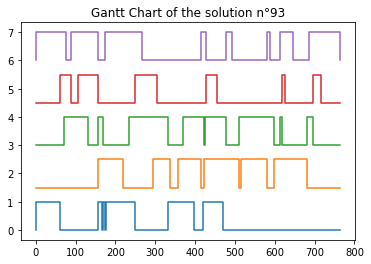

Makespan of the solution n°93 : 764
Regularity of the solution n°93 : 4108
Objective function of the solution n°93 : 3138512


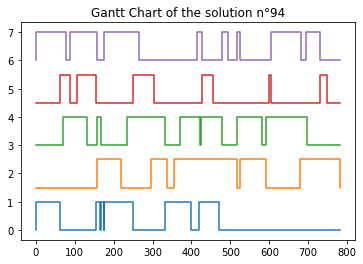

Makespan of the solution n°94 : 782
Regularity of the solution n°94 : 4108
Objective function of the solution n°94 : 3212456


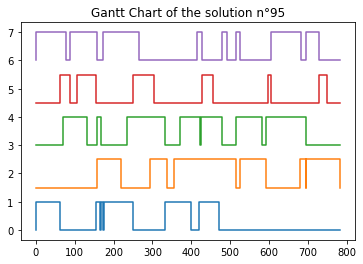

Makespan of the solution n°95 : 783
Regularity of the solution n°95 : 4108
Objective function of the solution n°95 : 3216564


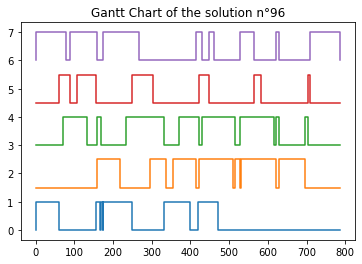

Makespan of the solution n°96 : 787
Regularity of the solution n°96 : 4140
Objective function of the solution n°96 : 3258180


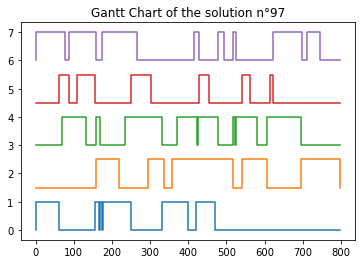

Makespan of the solution n°97 : 798
Regularity of the solution n°97 : 4222
Objective function of the solution n°97 : 3369156


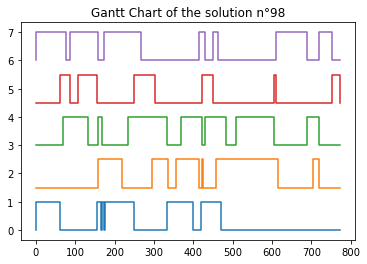

Makespan of the solution n°98 : 773
Regularity of the solution n°98 : 4268
Objective function of the solution n°98 : 3299164


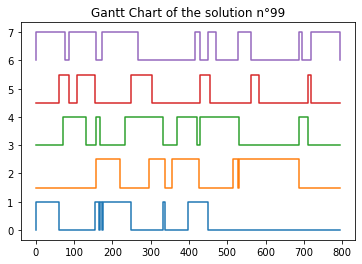

Makespan of the solution n°99 : 795
Regularity of the solution n°99 : 4270
Objective function of the solution n°99 : 3394650


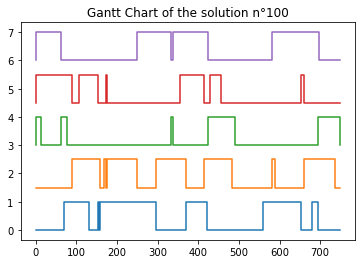

Makespan of the solution n°100 : 749
Regularity of the solution n°100 : 4320
Objective function of the solution n°100 : 3235680


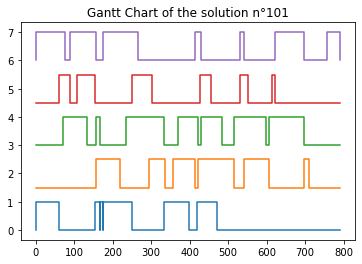

Makespan of the solution n°101 : 791
Regularity of the solution n°101 : 4286
Objective function of the solution n°101 : 3390226


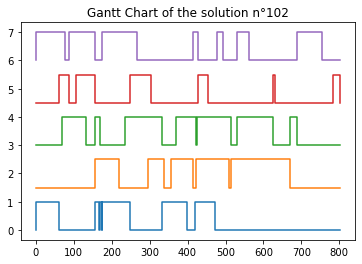

Makespan of the solution n°102 : 802
Regularity of the solution n°102 : 4436
Objective function of the solution n°102 : 3557672


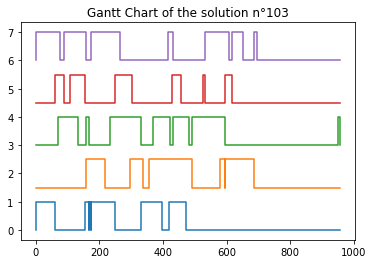

Makespan of the solution n°103 : 957
Regularity of the solution n°103 : 4300
Objective function of the solution n°103 : 4115100


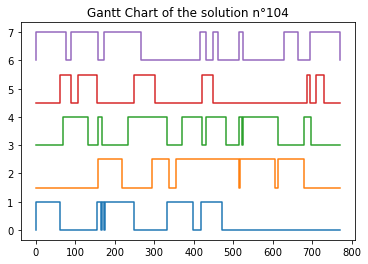

Makespan of the solution n°104 : 771
Regularity of the solution n°104 : 4498
Objective function of the solution n°104 : 3467958


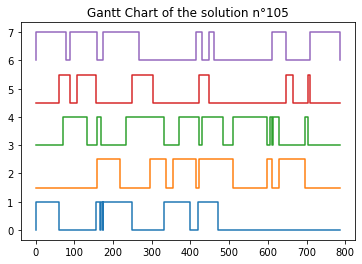

Makespan of the solution n°105 : 787
Regularity of the solution n°105 : 4492
Objective function of the solution n°105 : 3535204


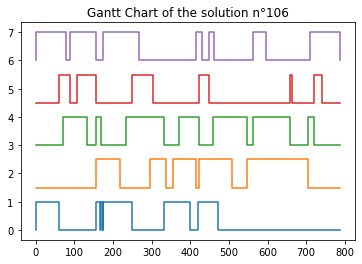

Makespan of the solution n°106 : 788
Regularity of the solution n°106 : 4512
Objective function of the solution n°106 : 3555456


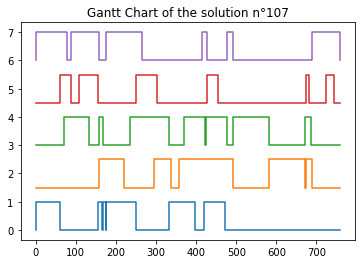

Makespan of the solution n°107 : 759
Regularity of the solution n°107 : 4542
Objective function of the solution n°107 : 3447378


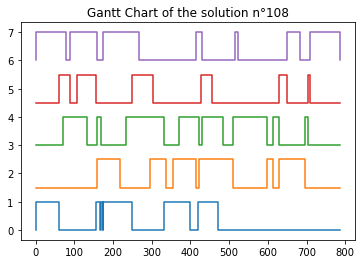

Makespan of the solution n°108 : 787
Regularity of the solution n°108 : 4578
Objective function of the solution n°108 : 3602886


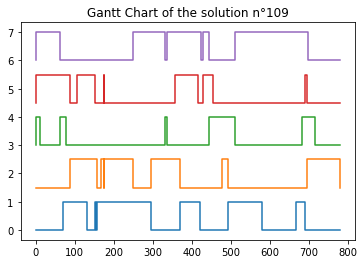

Makespan of the solution n°109 : 781
Regularity of the solution n°109 : 4588
Objective function of the solution n°109 : 3583228


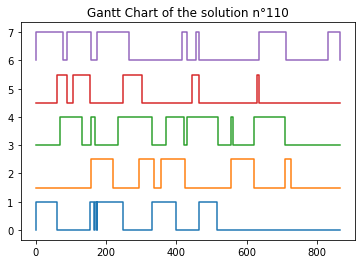

Makespan of the solution n°110 : 866
Regularity of the solution n°110 : 4726
Objective function of the solution n°110 : 4092716


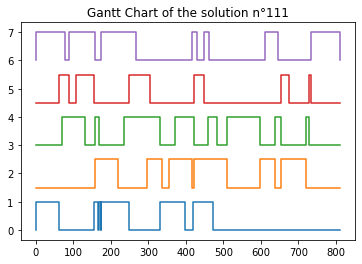

Makespan of the solution n°111 : 811
Regularity of the solution n°111 : 4860
Objective function of the solution n°111 : 3941460


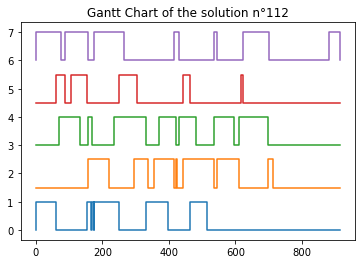

Makespan of the solution n°112 : 915
Regularity of the solution n°112 : 4812
Objective function of the solution n°112 : 4402980


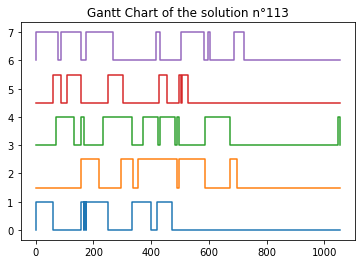

Makespan of the solution n°113 : 1055
Regularity of the solution n°113 : 4922
Objective function of the solution n°113 : 5192710


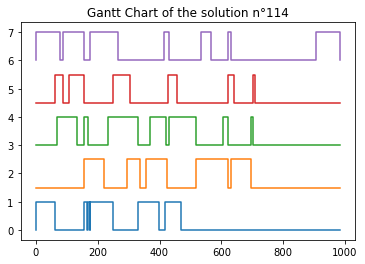

Makespan of the solution n°114 : 984
Regularity of the solution n°114 : 5162
Objective function of the solution n°114 : 5079408


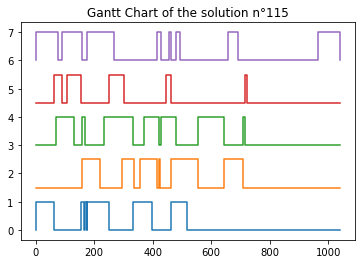

Makespan of the solution n°115 : 1041
Regularity of the solution n°115 : 5640
Objective function of the solution n°115 : 5871240


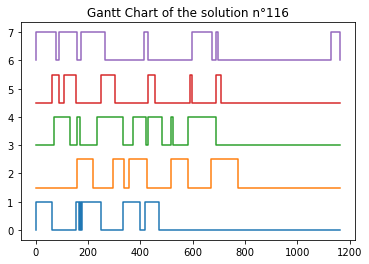

Makespan of the solution n°116 : 1163
Regularity of the solution n°116 : 5664
Objective function of the solution n°116 : 6587232


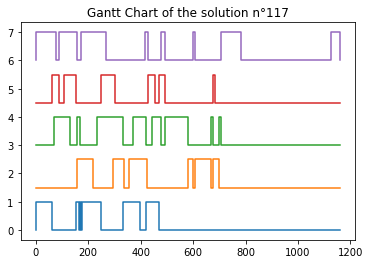

Makespan of the solution n°117 : 1161
Regularity of the solution n°117 : 6312
Objective function of the solution n°117 : 7328232


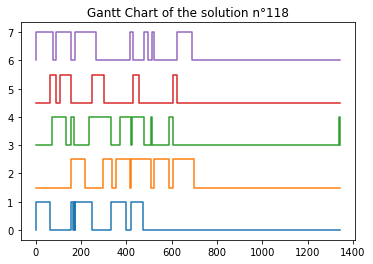

Makespan of the solution n°118 : 1343
Regularity of the solution n°118 : 6136
Objective function of the solution n°118 : 8240648


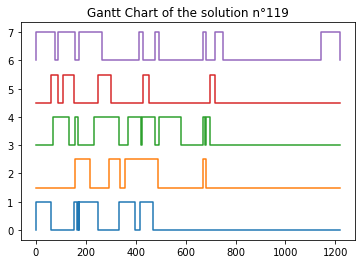

Makespan of the solution n°119 : 1219
Regularity of the solution n°119 : 6466
Objective function of the solution n°119 : 7882054


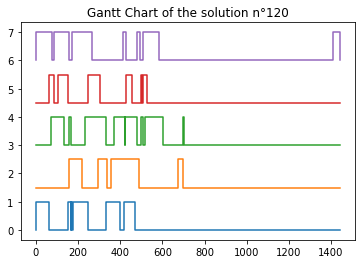

Makespan of the solution n°120 : 1443
Regularity of the solution n°120 : 6398
Objective function of the solution n°120 : 9232314


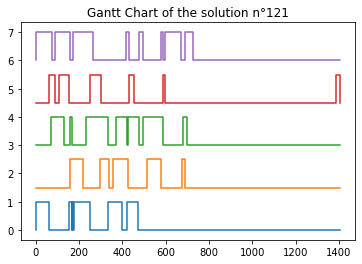

Makespan of the solution n°121 : 1405
Regularity of the solution n°121 : 6550
Objective function of the solution n°121 : 9202750


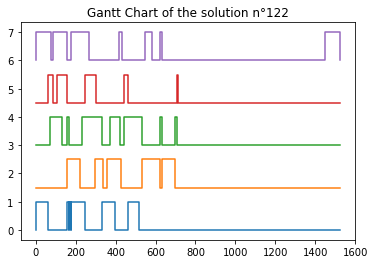

Makespan of the solution n°122 : 1525
Regularity of the solution n°122 : 7060
Objective function of the solution n°122 : 10766500


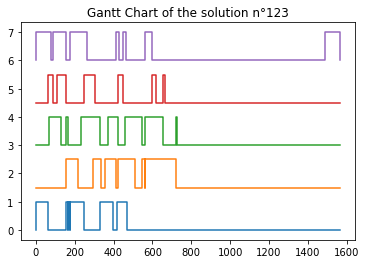

Makespan of the solution n°123 : 1566
Regularity of the solution n°123 : 7128
Objective function of the solution n°123 : 11162448


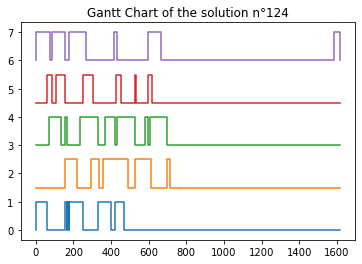

Makespan of the solution n°124 : 1617
Regularity of the solution n°124 : 7114
Objective function of the solution n°124 : 11503338


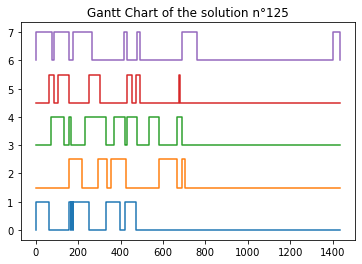

Makespan of the solution n°125 : 1436
Regularity of the solution n°125 : 7316
Objective function of the solution n°125 : 10505776


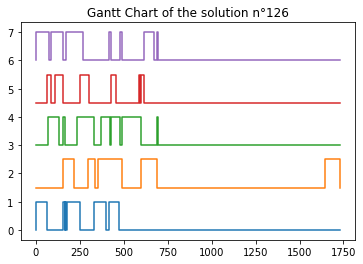

Makespan of the solution n°126 : 1731
Regularity of the solution n°126 : 7556
Objective function of the solution n°126 : 13079436


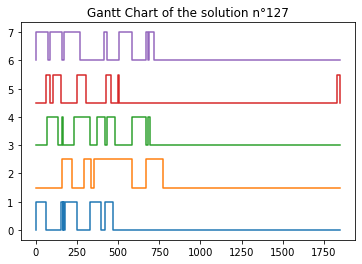

Makespan of the solution n°127 : 1848
Regularity of the solution n°127 : 7736
Objective function of the solution n°127 : 14296128


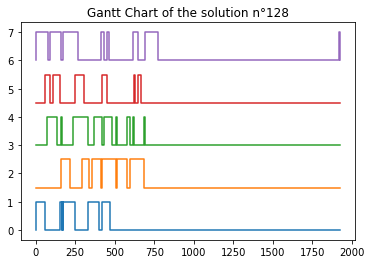

Makespan of the solution n°128 : 1926
Regularity of the solution n°128 : 8646
Objective function of the solution n°128 : 16652196


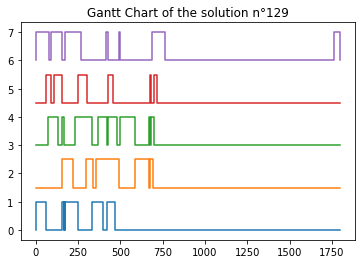

Makespan of the solution n°129 : 1799
Regularity of the solution n°129 : 8782
Objective function of the solution n°129 : 15798818


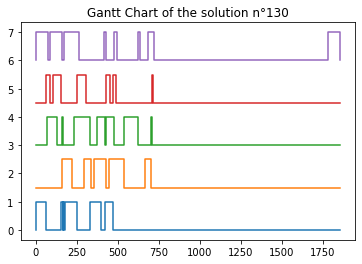

Makespan of the solution n°130 : 1854
Regularity of the solution n°130 : 8944
Objective function of the solution n°130 : 16582176


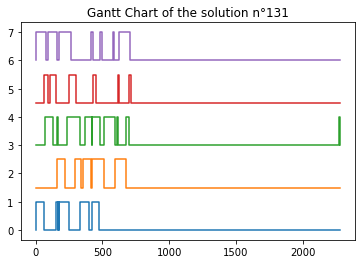

Makespan of the solution n°131 : 2282
Regularity of the solution n°131 : 10180
Objective function of the solution n°131 : 23230760


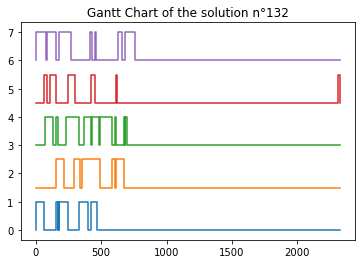

Makespan of the solution n°132 : 2326
Regularity of the solution n°132 : 10470
Objective function of the solution n°132 : 24353220


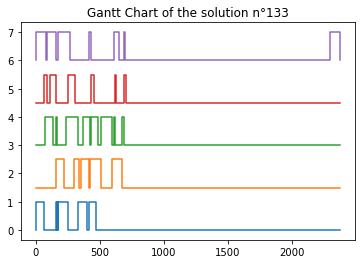

Makespan of the solution n°133 : 2375
Regularity of the solution n°133 : 10516
Objective function of the solution n°133 : 24975500


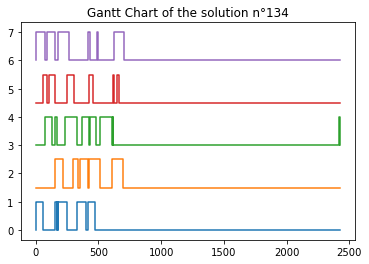

Makespan of the solution n°134 : 2427
Regularity of the solution n°134 : 10560
Objective function of the solution n°134 : 25629120


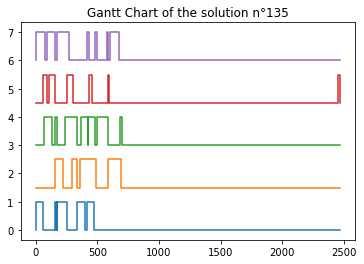

Makespan of the solution n°135 : 2468
Regularity of the solution n°135 : 10802
Objective function of the solution n°135 : 26659336


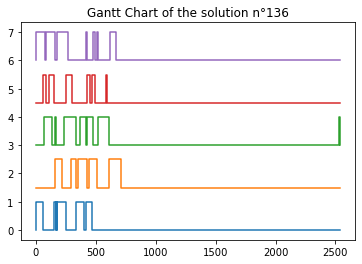

Makespan of the solution n°136 : 2539
Regularity of the solution n°136 : 10972
Objective function of the solution n°136 : 27857908


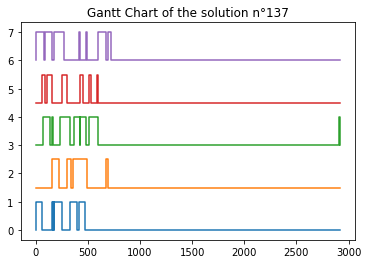

Makespan of the solution n°137 : 2919
Regularity of the solution n°137 : 12754
Objective function of the solution n°137 : 37228926


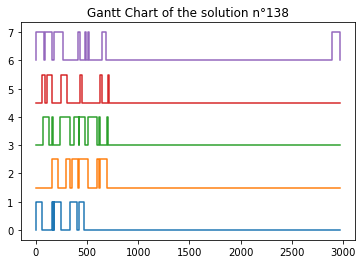

Makespan of the solution n°138 : 2971
Regularity of the solution n°138 : 13314
Objective function of the solution n°138 : 39555894


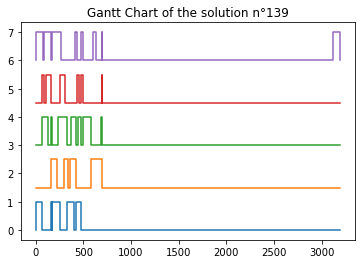

Makespan of the solution n°139 : 3194
Regularity of the solution n°139 : 13892
Objective function of the solution n°139 : 44371048


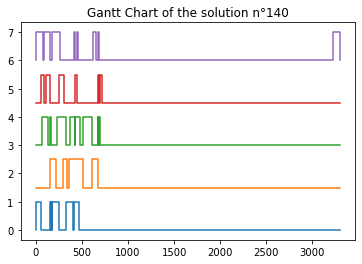

Makespan of the solution n°140 : 3300
Regularity of the solution n°140 : 14526
Objective function of the solution n°140 : 47935800


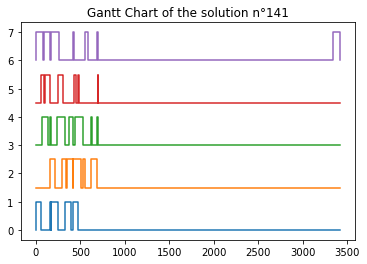

Makespan of the solution n°141 : 3421
Regularity of the solution n°141 : 14576
Objective function of the solution n°141 : 49864496


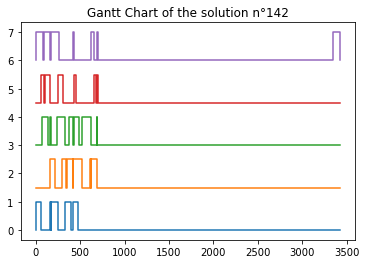

Makespan of the solution n°142 : 3427
Regularity of the solution n°142 : 14994
Objective function of the solution n°142 : 51384438


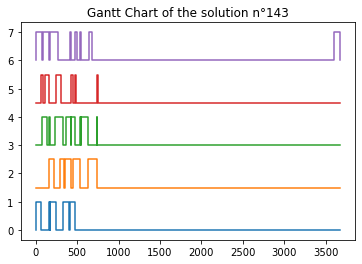

Makespan of the solution n°143 : 3675
Regularity of the solution n°143 : 16286
Objective function of the solution n°143 : 59851050


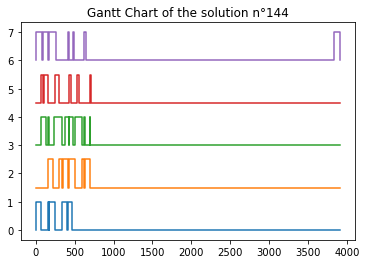

Makespan of the solution n°144 : 3913
Regularity of the solution n°144 : 16930
Objective function of the solution n°144 : 66247090


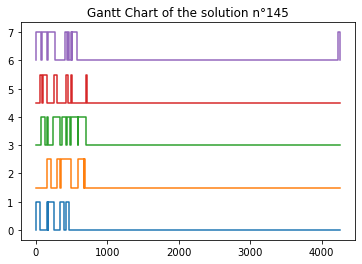

Makespan of the solution n°145 : 4258
Regularity of the solution n°145 : 17224
Objective function of the solution n°145 : 73339792


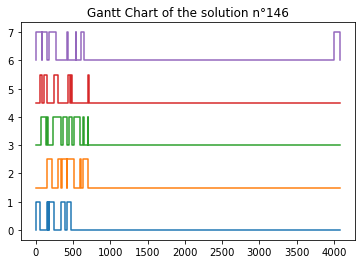

Makespan of the solution n°146 : 4082
Regularity of the solution n°146 : 17636
Objective function of the solution n°146 : 71990152


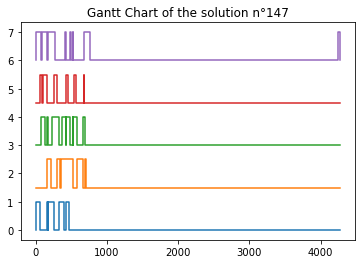

Makespan of the solution n°147 : 4274
Regularity of the solution n°147 : 18662
Objective function of the solution n°147 : 79761388


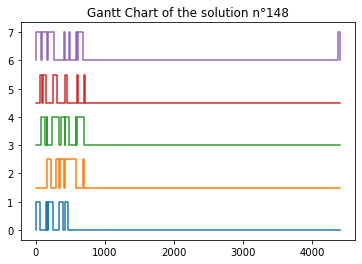

Makespan of the solution n°148 : 4410
Regularity of the solution n°148 : 18658
Objective function of the solution n°148 : 82281780


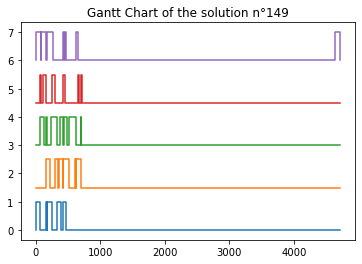

Makespan of the solution n°149 : 4715
Regularity of the solution n°149 : 20204
Objective function of the solution n°149 : 95261860


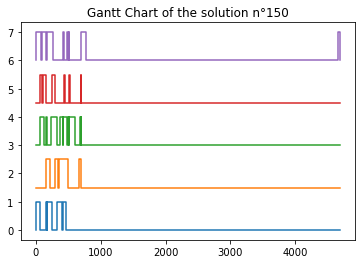

Makespan of the solution n°150 : 4691
Regularity of the solution n°150 : 20474
Objective function of the solution n°150 : 96043534


In [12]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))